# Map-Reduced AIS Clustering (K-means Sampling)

Note: Example notebook data for 5 days used 

In [ ]:
# --- Cell 1: Imports ---
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.spatial import Voronoi
import sys

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

DATA_ROOT = PROJECT_ROOT / 'data' / 'processed' / 'map_reduced'
print(f'Data root: {DATA_ROOT}')

Data root: D:\DTU\AIS-MDA\data\processed\map_reduced


In [42]:
# --- Cell 2: Load Data using AISDatasetBase ---
# We use the Base class because we just want the raw sequences, not the X/Y split
from src.utils.datasets import AISDatasetBase

MAX_SEQLEN = 128
datasets = {}
for split in ('train', 'val', 'test'):
    split_dir = DATA_ROOT / split
    if not split_dir.exists():
        print(f"Skipping {split}, dir not found.")
        continue
    
    datasets[split] = AISDatasetBase(str(split_dir), max_seqlen=MAX_SEQLEN)
    print(f"{split}: {len(datasets[split])} pickles loaded")


[AISDataset] Scanning 1749 files. Mode=head, Oversample=1x
[AISDataset] Building start-index lookup tables...
[AISDataset] Metadata ready.
train: 1749 pickles loaded
[AISDataset] Scanning 218 files. Mode=head, Oversample=1x
[AISDataset] Building start-index lookup tables...
[AISDataset] Metadata ready.
val: 218 pickles loaded
[AISDataset] Scanning 217 files. Mode=head, Oversample=1x
[AISDataset] Building start-index lookup tables...
[AISDataset] Metadata ready.
test: 217 pickles loaded


In [43]:
# --- Cell 3: Gather Coordinates ---
def gather_lat_lon(dataset, max_sequences=400):
    coords = []
    upper = min(len(dataset), max_sequences)
    for idx in range(upper):
        # Base returns: (seq, mask, seqlen, mmsi, time_start)
        seq, mask, seqlen, *_ = dataset[idx]
        seqlen = int(seqlen.item())
        # Collect Lat/Lon columns (0 and 1)
        coords.append(seq[:seqlen, :2].numpy())
        
    if not coords:
        return np.empty((0, 2))
    return np.concatenate(coords, axis=0)

train_coords = gather_lat_lon(datasets['train'])
# val/test optional
# val_coords = gather_lat_lon(datasets['val']) 

In [44]:
# --- Cell 4: Denormalize ---
#from src.preprocessing import LAT_MIN, LAT_MAX, LON_MIN, LON_MAX

LON_MIN = 5.0
LON_MAX = 17.0
LAT_MIN = 54.0
LAT_MAX = 59.0

def denormalize_coords(coords):
    if coords.size == 0: return coords
    lat = coords[:, 0] * (LAT_MAX - LAT_MIN) + LAT_MIN
    lon = coords[:, 1] * (LON_MAX - LON_MIN) + LON_MIN
    return np.column_stack([lat, lon])

train_coords_deg = denormalize_coords(train_coords)


Running KMeans sweep...


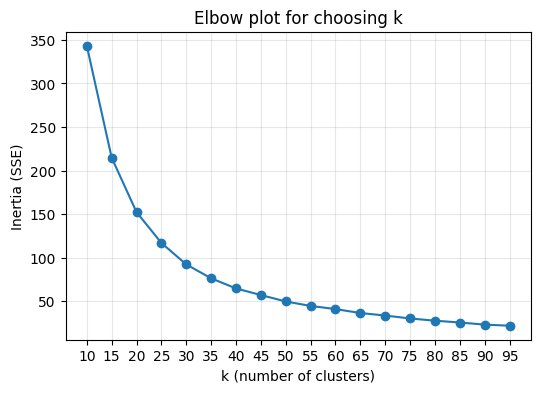

In [45]:
# --- Cell 5: Elbow Plot ---
ks = list(range(10, 100, 5))
inertias = []
print("Running KMeans sweep...")
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(train_coords)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(ks, inertias, marker='o')
plt.xticks(ks)
plt.xlabel('k (number of clusters)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow plot for choosing k')
plt.grid(True, alpha=0.3)
plt.show()

In [46]:
# --- Cell 6: Fit Final KMeans ---
N_CLUSTERS = 50  # Adjust based on Elbow plot
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
kmeans.fit(train_coords)
print(f'Train inertia: {kmeans.inertia_:.4f}')

Train inertia: 49.7846


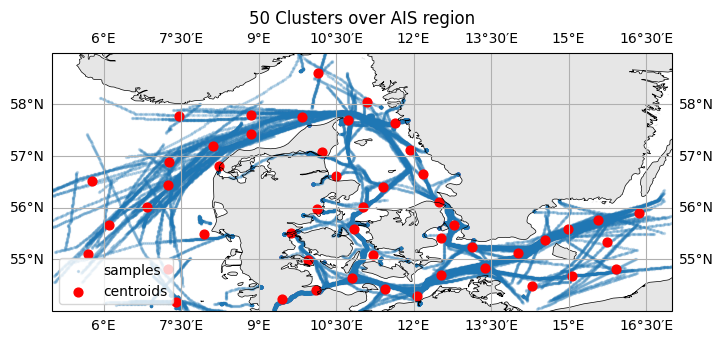

In [47]:
# --- Cell 7: Plot Clusters on Map ---
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='0.9')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Plot samples
ax.scatter(train_coords_deg[:, 1], train_coords_deg[:, 0], s=2, alpha=0.2, 
           transform=ccrs.PlateCarree(), label='samples')

# Plot centroids
centers_deg = denormalize_coords(kmeans.cluster_centers_)
ax.scatter(centers_deg[:, 1], centers_deg[:, 0], c='red', s=40, 
           transform=ccrs.PlateCarree(), label='centroids')

ax.set_title(f'{N_CLUSTERS} Clusters over AIS region')
ax.legend(loc='lower left')
plt.show()

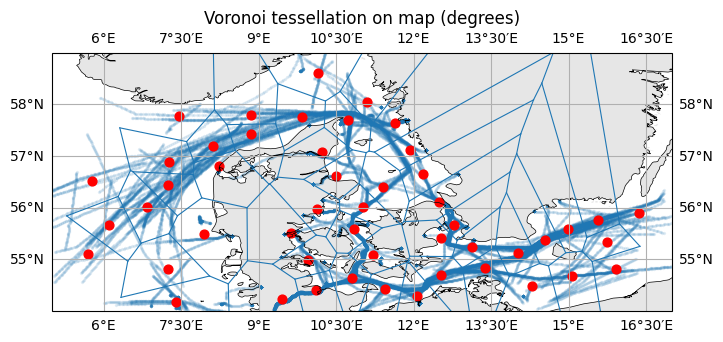

In [48]:
# --- Cell 8: Voronoi Tessellation ---
centers_lon_lat = np.stack([centers_deg[:, 1], centers_deg[:, 0]], axis=1)
vor = Voronoi(centers_lon_lat)

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='0.9')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Draw Voronoi ridges
for simplex in vor.ridge_vertices:
    if -1 in simplex: continue
    pts = vor.vertices[simplex]
    ax.plot(pts[:, 0], pts[:, 1], color='tab:blue', linewidth=0.8, transform=ccrs.PlateCarree())

ax.scatter(train_coords_deg[:, 1], train_coords_deg[:, 0], s=2, alpha=0.1, 
           transform=ccrs.PlateCarree(), label='samples')
ax.scatter(centers_lon_lat[:, 0], centers_lon_lat[:, 1], c='red', s=40, 
           transform=ccrs.PlateCarree(), label='centroids')

ax.set_title('Voronoi tessellation on map (degrees)')
plt.show()

# Start Mode Comparison (Head vs. K-means)


In [ ]:

# --- Imports & Path Setup ---
from pathlib import Path
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import torch
import sys
import pickle

# Adjust path to project root
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / 'src').exists():
    raise RuntimeError('Cannot locate project root (missing src/).')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# Point this to your processed data folder
DATA_ROOT = PROJECT_ROOT / 'data' / 'processed' / 'map_reduced' / 'train'
print(f'Project root: {PROJECT_ROOT}')
print(f'Data dir: {DATA_ROOT}')



Project root: D:\DTU\AIS-MDA
Data dir: D:\DTU\AIS-MDA\data\processed\map_reduced\train


In [70]:
# --- Load Datasets ---
from src.utils.datasets import make_ais_dataset
# Import constants from your new preprocessing.py
LON_MIN = 5.0
LON_MAX = 17.0
LAT_MIN = 54.0
LAT_MAX = 59.0

WINDOW = 64
HORIZON = 12

# Config for the internal KMeans in AISDataset
KMEANS_CFG = {
    'n_clusters': 50,
    'samples_per_traj': 128,
    'max_points': 200000,
    'n_init': 10,
    'random_state': 42,
}

# 1. Head-start dataset (Start from beginning of trajectories)
ds_head = make_ais_dataset(
    str(DATA_ROOT), 
    window=WINDOW, 
    horizon=HORIZON,
    output_features=2, 
    filter_short=True,
    start_mode='head', 
    kmeans_config=None
)

# 2. KMeans dataset (Start from clusters)
ds_kmeans = make_ais_dataset(
    str(DATA_ROOT), 
    window=WINDOW, 
    horizon=HORIZON,
    output_features=2, 
    filter_short=True,
    start_mode='kmeans', 
    kmeans_config=KMEANS_CFG
)

print(f'Head-start dataset items: {len(ds_head)}')
print(f'K-means dataset items: {len(ds_kmeans)}')


[AISDataset] Scanning 1749 files. Mode=head, Oversample=20x
[AISDataset] Building start-index lookup tables...
[AISDataset] Metadata ready.
[AISDataset] Scanning 1749 files. Mode=kmeans, Oversample=20x
[AISDataset] Fitting KMeans(50) on 200000 points...
[AISDataset] Building start-index lookup tables...
[AISDataset] Metadata ready.
Head-start dataset items: 31880
K-means dataset items: 31880


In [71]:
# --- Helper Functions ---
def denormalize_lat_lon(lat_lon):
    """Convert normalized [0,1] coords back to degrees."""
    if lat_lon.size == 0:
        return lat_lon
    # Ensure we work on a copy to avoid modifying tensors in place
    lat_lon = np.array(lat_lon, dtype=np.float32)
    lat = lat_lon[:, 0] * (LAT_MAX - LAT_MIN) + LAT_MIN
    lon = lat_lon[:, 1] * (LON_MAX - LON_MIN) + LON_MIN
    return np.column_stack([lat, lon])

def sample_start_coords(dataset, n_samples=256):
    coords = []
    upper = min(len(dataset), n_samples)
    # New dataset returns (X, Y), where X is [Window, Features]
    for idx in range(upper):
        X, Y = dataset[idx]
        start_pos = X[0, :2].numpy() # Take first point (Lat, Lon)
        coords.append(start_pos[None, :])
        
    if not coords:
        return np.empty((0, 2))
    return denormalize_lat_lon(np.concatenate(coords, axis=0))

start_head = sample_start_coords(ds_head, 400)
start_kmeans = sample_start_coords(ds_kmeans, 400)
print(f'Sampled {len(start_head)} head-start windows, {len(start_kmeans)} k-means windows')



Sampled 400 head-start windows, 400 k-means windows


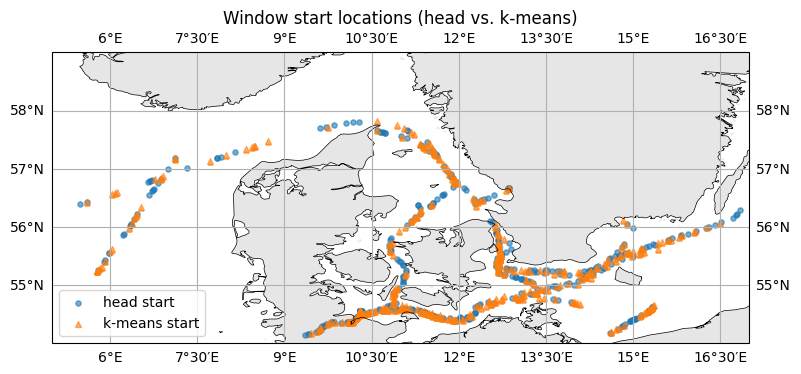

In [72]:
# --- Plot Window Start Locations ---
fig = plt.figure(figsize=(9, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.add_feature(cfeature.LAND, facecolor='0.9')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.scatter(start_head[:, 1], start_head[:, 0], s=14, c='tab:blue', alpha=0.6,
           transform=ccrs.PlateCarree(), label='head start')
ax.scatter(start_kmeans[:, 1], start_kmeans[:, 0], s=18, c='tab:orange', alpha=0.6, marker='^',
           transform=ccrs.PlateCarree(), label='k-means start')

ax.set_title('Window start locations (head vs. k-means)')
ax.legend(loc='lower left')
plt.show()

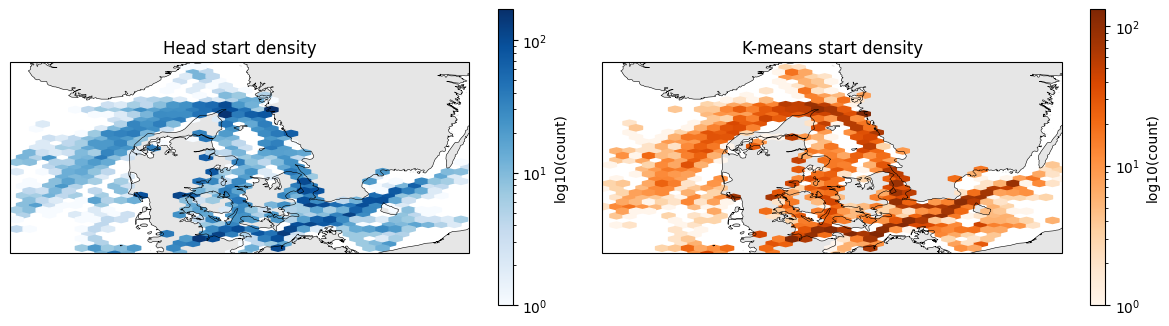

--- Cluster coverage metrics ---
Head mode:    50 / 50 clusters touched; entropy=3.729; mean dist=0.0285
K-means mode: 50 / 50 clusters touched; entropy=3.750; mean dist=0.0297

Clusters with largest positive coverage gain (k-means vs head):
  cluster 40: +116 starts near lat=54.58, lon=11.08
  cluster 36: +78 starts near lat=56.05, lon=11.07
  cluster 45: +74 starts near lat=57.47, lon=11.37
  cluster 33: +59 starts near lat=57.74, lon=9.41
  cluster 27: +49 starts near lat=55.84, lon=16.21


In [73]:
# --- Quantitative Comparison & Density Map ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

def collect_start_positions(dataset, max_items=None):
    """
    Collect start positions from the new AISDataset format.
    """
    coords_deg = []
    coords_norm = []
    
    # If max_items is None, use full length, else clamp it
    total = len(dataset) if max_items is None else min(len(dataset), max_items)
    
    # Use dataset._valid_indices to access raw data if needed, 
    # but iterating the dataset directly is safer for the new API.
    for idx in range(total):
        # New dataset returns tuple (X, Y)
        # X shape: [Window, Features]
        X, Y = dataset[idx]
        
        # Extract start position (first point of X)
        # X is a tensor, so convert to numpy
        start_norm = X[0, :2].numpy()
        
        coords_norm.append(start_norm)
        # Denormalize for plotting (using your helper function)
        coords_deg.append(denormalize_lat_lon(start_norm[None, :])[0])
        
    return np.asarray(coords_deg), np.asarray(coords_norm)

# Collect data (Limit to e.g., 5000 samples for speed, or None for all)
print("Collecting start positions...")
head_deg, head_norm = collect_start_positions(ds_head, max_items=10000)
kmeans_deg, kmeans_norm = collect_start_positions(ds_kmeans, max_items=10000)

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})

for ax, coords, title, cmap in [
        (axes[0], head_deg, 'Head start density', 'Blues'),
        (axes[1], kmeans_deg, 'K-means start density', 'Oranges')
    ]:
    # Use prep constants for extent
    ax.set_extent([prep.LON_MIN, prep.LON_MAX, prep.LAT_MIN, prep.LAT_MAX], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='0.9')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
    
    # Hexbin plot
    if len(coords) > 0:
        hb = ax.hexbin(coords[:, 1], coords[:, 0], gridsize=35, cmap=cmap, bins='log', mincnt=1, transform=ccrs.PlateCarree())
        plt.colorbar(hb, ax=ax, orientation='vertical', shrink=0.8, label='log10(count)')
    
    ax.set_title(title)

plt.tight_layout()
plt.show()

# --- Statistics ---
# Access internal KMeans model from the kmeans dataset
model = getattr(ds_kmeans, '_kmeans_model', None)
centroids = getattr(ds_kmeans, '_centroids', None)

if model is not None and centroids is not None and len(head_norm) > 0 and len(kmeans_norm) > 0:
    def cluster_stats(norm_coords):
        # Ensure dtype matches model expectation (usually float64 or float32)
        norm_coords = norm_coords.astype(model.cluster_centers_.dtype, copy=False)
        
        # Predict cluster labels
        labels = model.predict(norm_coords)
        
        # Count occurrences per cluster
        counts = np.bincount(labels, minlength=len(model.cluster_centers_))
        
        # Calculate probability distribution
        probs = counts[counts > 0] / counts.sum()
        
        # Coverage: how many clusters have at least 1 sample?
        coverage = np.count_nonzero(counts)
        
        # Entropy: measure of uniformity
        ent = float(-np.sum(probs * np.log(probs)))
        
        # Mean distance to assigned centroid
        dists = np.linalg.norm(norm_coords - model.cluster_centers_[labels], axis=1)
        
        return labels, counts, coverage, ent, float(dists.mean())

    head_labels, head_counts, head_cov, head_ent, head_mean_dist = cluster_stats(head_norm)
    km_labels, km_counts, km_cov, km_ent, km_mean_dist = cluster_stats(kmeans_norm)

    print('--- Cluster coverage metrics ---')
    print(f'Head mode:    {head_cov} / {len(centroids)} clusters touched; entropy={head_ent:.3f}; mean dist={head_mean_dist:.4f}')
    print(f'K-means mode: {km_cov} / {len(centroids)} clusters touched; entropy={km_ent:.3f}; mean dist={km_mean_dist:.4f}')
    
    # Find biggest gainers
    diff = (km_counts - head_counts)
    top = np.argsort(diff)[-5:][::-1]
    
    print('\nClusters with largest positive coverage gain (k-means vs head):')
    for cid in top:
        if diff[cid] <= 0:
            continue
        # Denormalize centroid for display
        c_norm = model.cluster_centers_[cid][None, :2]
        lat_lon = denormalize_lat_lon(c_norm)[0]
        print(f'  cluster {cid}: +{diff[cid]} starts near lat={lat_lon[0]:.2f}, lon={lat_lon[1]:.2f}')
else:
    print('K-means model not available or data empty; skipping coverage metrics.')

Sample 27110: Window Start belongs to Cluster 30 (Dist: 0.0278)
Sample 25927: Window Start belongs to Cluster 8 (Dist: 0.0658)
Sample 20301: Window Start belongs to Cluster 11 (Dist: 0.0083)
Sample 16291: Window Start belongs to Cluster 2 (Dist: 0.0371)
Sample 8599: Window Start belongs to Cluster 10 (Dist: 0.0157)
Sample 1306: Window Start belongs to Cluster 10 (Dist: 0.0375)
Sample 526: Window Start belongs to Cluster 24 (Dist: 0.0530)
Sample 9812: Window Start belongs to Cluster 40 (Dist: 0.0214)
Sample 5587: Window Start belongs to Cluster 49 (Dist: 0.0149)
Sample 2398: Window Start belongs to Cluster 19 (Dist: 0.0168)


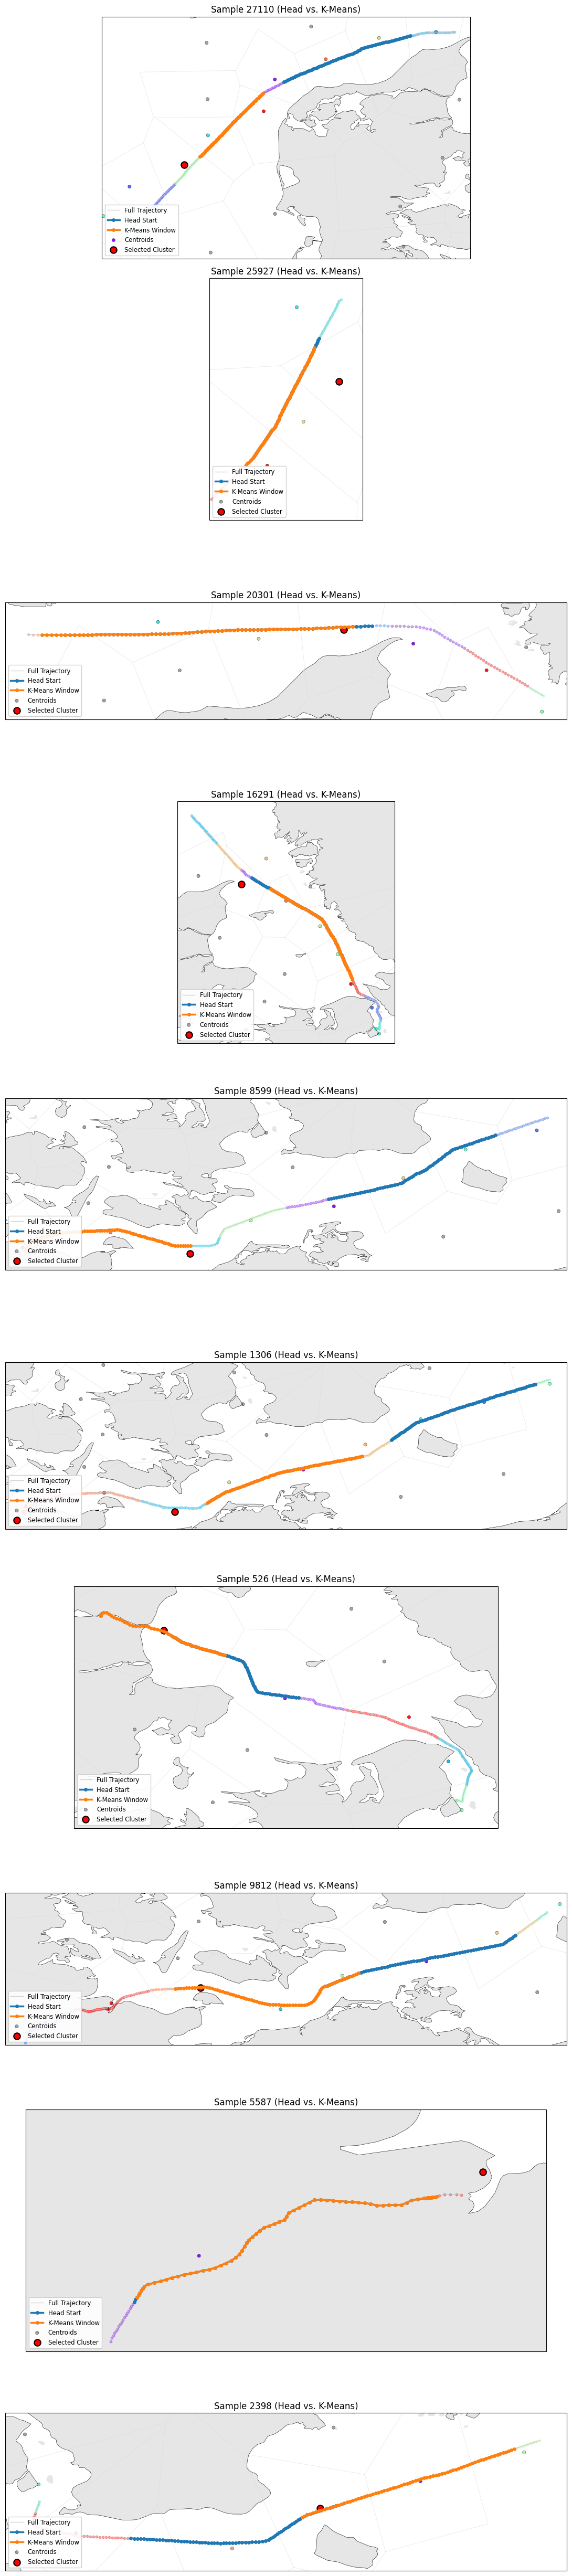

In [78]:
# --- Cell 5: Visualize Trajectories & Windows ---
import joblib
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.spatial import Voronoi
from pathlib import Path
from pickle import UnpicklingError

# --- Helper Functions ---

LAT_MIN, LAT_MAX = 54.0, 59.0
LON_MIN, LON_MAX = 5.0, 17.0

def denormalize_lat_lon(lat_lon):
    if lat_lon.size == 0: return lat_lon
    lat_lon = lat_lon.astype(np.float32)
    lat = lat_lon[:, 0] * (LAT_MAX - LAT_MIN) + LAT_MIN
    lon = lat_lon[:, 1] * (LON_MAX - LON_MIN) + LON_MIN
    return np.column_stack([lat, lon])

def get_window_path(dataset, idx):
    X, Y = dataset[idx]
    X_np = X.numpy()[:, :2]
    Y_np = Y.numpy()[:, :2]
    full_window_norm = np.concatenate([X_np, Y_np], axis=0)
    return denormalize_lat_lon(full_window_norm), full_window_norm.astype(np.float32)

def get_full_traj(dataset, idx):
    orig_idx = dataset._valid_indices[idx]
    file_idx = orig_idx // dataset.epoch_samples
    fname = dataset.file_list[file_idx]
    path = Path(dataset.data_dir) / fname
    
    try:
        with open(path, 'rb') as f:
            data = pickle.load(f)
    except (UnpicklingError, EOFError):
        try:
            data = joblib.load(path)
        except Exception:
            return np.zeros((0, 2)), np.zeros((0, 2))
            
    if isinstance(data, dict) and "traj" in data:
        traj = data["traj"]
    else:
        traj = data
    return denormalize_lat_lon(traj[:, :2].astype(np.float32)), traj[:, :2].astype(np.float32)

# --- Plotting Logic ---
rng = np.random.default_rng(0)
sample_indices = rng.choice(len(ds_head), size=min(10, len(ds_head)), replace=False)

centers_norm = getattr(ds_kmeans, '_centroids', None)
model = getattr(ds_kmeans, '_kmeans_model', None)
centers_deg = denormalize_lat_lon(centers_norm) if centers_norm is not None else None

centers_lonlat = None
vor = None
if centers_deg is not None:
    centers_lonlat = np.column_stack([centers_deg[:, 1], centers_deg[:, 0]])
    if len(centers_lonlat) >= 4:
        vor = Voronoi(centers_lonlat)

fig, axes = plt.subplots(len(sample_indices), 1, figsize=(11, 5 * len(sample_indices)), 
                         subplot_kw={'projection': ccrs.PlateCarree()})
if len(sample_indices) == 1: axes = np.array([axes])

for row, idx in enumerate(sample_indices):
    ax = axes[row]
    full_deg, full_norm = get_full_traj(ds_head, idx)
    win_head_deg, _ = get_window_path(ds_head, idx)
    win_km_deg, win_km_norm = get_window_path(ds_kmeans, idx)

    # Dynamic Extent
    pad = 0.2
    lat_min = max(LAT_MIN, full_deg[:, 0].min() - pad)
    lat_max = min(LAT_MAX, full_deg[:, 0].max() + pad)
    lon_min = max(LON_MIN, full_deg[:, 1].min() - pad)
    lon_max = min(LON_MAX, full_deg[:, 1].max() + pad)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND, facecolor='0.9')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.4)

    # Plot Voronoi
    if vor is not None:
        for ridge in vor.ridge_vertices:
            if -1 in ridge: continue
            pts = vor.vertices[ridge]
            # Clip to view
            if np.all((pts[:,0] >= lon_min-1) & (pts[:,0] <= lon_max+1) & 
                      (pts[:,1] >= lat_min-1) & (pts[:,1] <= lat_max+1)):
                ax.plot(pts[:, 0], pts[:, 1], color='0.85', linewidth=0.6, alpha=0.6, transform=ccrs.PlateCarree())

    # Plot Lines
    ax.plot(full_deg[:, 1], full_deg[:, 0], '-', color='0.75', linewidth=1.0, alpha=0.7, 
            transform=ccrs.PlateCarree(), label='Full Trajectory')
    ax.plot(win_head_deg[:, 1], win_head_deg[:, 0], '-o', linewidth=2.5, color='tab:blue', 
            markersize=4, transform=ccrs.PlateCarree(), label='Head Start')
    ax.plot(win_km_deg[:, 1], win_km_deg[:, 0], '-o', linewidth=2.5, color='tab:orange', 
            markersize=4, transform=ccrs.PlateCarree(), label='K-Means Window')

    # Plot Clusters
    if centers_deg is not None and model is not None:
        full_norm_cast = full_norm.astype(model.cluster_centers_.dtype)
        labels = model.predict(full_norm_cast)
        unique_labels = np.unique(labels)
        colors = cm.rainbow(np.linspace(0, 1, max(1, len(unique_labels))))
        label_color_map = {lab: col for lab, col in zip(unique_labels, colors)}

        # 1. Colored Segments
        for lab, color in zip(unique_labels, colors):
            mask = labels == lab
            seg = full_deg[mask]
            # No label to avoid clutter
            ax.scatter(seg[:, 1], seg[:, 0], s=10, color=color, alpha=0.35, transform=ccrs.PlateCarree())
            
        # 2. Centroids (All Grey unless active)
        center_colors = ['0.6'] * len(centers_deg)
        for lab, col in label_color_map.items():
            center_colors[lab] = col # Highlight active clusters
            
        # Add 'Centroids' to legend only once
        ax.scatter(centers_deg[:, 1], centers_deg[:, 0], s=20, c=center_colors, 
                   edgecolors='k', linewidths=0.3, alpha=0.9, transform=ccrs.PlateCarree(), label='Centroids')

        # 3. Selected Cluster
        if len(win_km_norm) > 0:
            win_km_norm = win_km_norm.astype(model.cluster_centers_.dtype)
            sel_label = int(model.predict(win_km_norm[:1])[0])
            start_pt = win_km_norm[:1].astype(model.cluster_centers_.dtype)
            predicted_cluster = int(model.predict(start_pt)[0])

            # Calculate distance to this centroid
            centroid = model.cluster_centers_[predicted_cluster]
            dist = np.linalg.norm(start_pt - centroid)

            print(f"Sample {idx}: Window Start belongs to Cluster {predicted_cluster} (Dist: {dist:.4f})")

            ax.scatter(centers_deg[sel_label, 1], centers_deg[sel_label, 0], s=80, c='red', 
                       edgecolors='black', linewidths=1.5, transform=ccrs.PlateCarree(), label='Selected Cluster')

    ax.set_title(f'Sample {idx} (Head vs. K-Means)')
    
    # --- FIX: Force Legend on Every Plot ---
    # Deduplicate labels to avoid repeating 'Centroids' etc.
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='lower left', fontsize='small', framealpha=0.9)

plt.tight_layout()
plt.show()